In [1]:
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *







process_gen_modes=["wmt_samples0", "only_qwen_8b"]



#ok, current plan:
dfs_by_model,processGens,(root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric)= get_dfs_by_model(process_gen_modes)
examples_df = pd.concat(list(dfs_by_model.values()))



/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


mode is wmttask_names is ['wmt_14_language_pair_de_en_']
mode is wmttask_names is ['wmt_14_language_pair_de_en_']


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
# print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

df=next(iter(dfs_by_model.values()))

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['Qwen/Qwen3-8B'] 
 	 custom_metrics[]
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_100_eval_500_first_inst_0 
 	 instance_metrics ['comet']
        example_comet  beam_num                    task_name  \
100000       0.865341         1  wmt_14_language_pair_de_en_   
100001       0.861965         1  wmt_14_language_pair_de_en_   

                                   model  example_idx  rank  \
100000  meta_llama_Llama_3.1_8B_Instruct            0   100   
100001  meta_llama_Llama_3.1_8B_Instruct            1    99   

                       suite  instanceID  \
100000  sample_100_eval_1000           0   
100001  sample_100_eval_1000           0   

                                                     text  completion_length  \
100000  He advised the parents of a boy whose penis ha...                178   
100001  He advised the parents of a boy whose penis wa...                177   

 

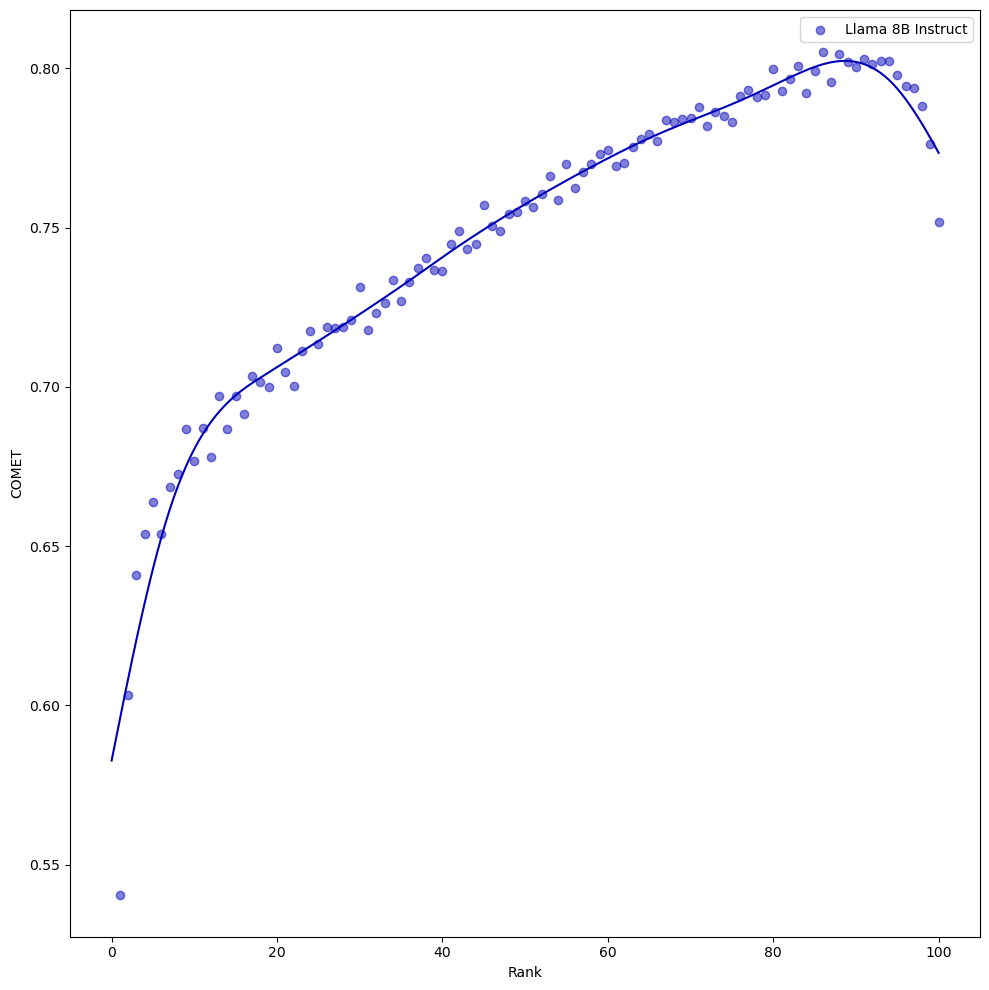

In [7]:


def plot_gam(df, compare_metric, ax,color, label):

    if(ax is None):
        _, ax = plt.subplots(figsize=(10, 10))
    
    grouped = df.groupby("example_idx")[["rank", compare_metric]].mean()


    # Assuming df is your dataframe
    X = grouped["rank"].values
    y = grouped[compare_metric].values


    gam = LinearGAM(s(0))

    # Fit the model to the data
    gam.fit(X, y)

    X_pred = np.linspace(0, 100,200).reshape(-1, 1)
    y_pred = gam.predict(X_pred)

    # Plot the results
    ax.scatter(X, y, alpha=0.5, color=color, label=label)
    ax.plot(X_pred, y_pred, color=color)
    return ax

def create_plots(kwargs_array, graph_func, figsize=None):


    #green-blue attempt
    # color_array=['#ff0015', "#ff00ea", "#9500ff", "#1500ff"]

    cmap = plt.get_cmap('seismic')
    color_array = [cmap(i) for i in [0.15, 0.35, 0.65, 0.85]]
    # color_array = [cmap(i) for i in np.linspace(0.25, 0.6, 4)]

    # =["#1f77b4",  "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

    ncols=len( kwargs_array)


    if figsize is None:
        figsize=(1*5, ncols*5)
        print(f"figsize is {figsize}")
    _, axes=plt.subplots(nrows=1, ncols= ncols, figsize=figsize)
    
    for col, kwargs_vect in enumerate(kwargs_array):

        ax=axes[col] if ncols>1 else axes
        for idx, kwargs in enumerate(kwargs_vect):
            kwargs["ax"]=ax
            kwargs["color"]=color_array[idx]
            ax=graph_func(**kwargs)
        ax.legend()
        ax.set_xlabel("Rank")

    left_ax=  axes[0] if ncols>1 else axes
    left_ax.set_ylabel(READABLE_LABELS[compare_metric])
    plt.tight_layout()
    plt.xlabel="Rank"

types_array=[
    ["meta_llama_Llama_3.1_8B_Instruct"]
             ]

def make_kwargs(model_name):
    return {"df": dfs_by_model[model_name], "compare_metric":compare_metric, "label":get_model_details(model_name)["name"]}

kwargs_array=[ [make_kwargs(model) for model in models_vect]   for models_vect in types_array]

create_plots(kwargs_array=kwargs_array, graph_func=plot_gam, figsize=(10,10))

In [4]:
#ok, for output_logprob, we want to 
#1) only keep logprob and compare_metric
#2) rank each sentence by compare_metric to get output_rank
#3) rank each item within the sentence by compare_metric to get sentence_rank
#4) print correlation of compare_metric and output_rank
#4) print correlation of compare_metric and sentence_rank

def get_rank_correlations(df, compare_metric):
    instanceID="instanceID"
    rank_df=df[[compare_metric, instanceID]]


    rank_df["output_rank"] = rank_df.groupby(instanceID)[compare_metric].rank(ascending=False, method='first')
    rank_df["output_rank"] = rank_df["output_rank"].astype(int)


    sentence_avg = rank_df.groupby(instanceID)[compare_metric].mean().reset_index()
    sentence_avg=sentence_avg.rename(columns={compare_metric:"sentence_ave"})
    # print(sentence_avg.head(1))
    # sentence_avg["sentence_ave"] = sentence_avg[compare_metric].rank(ascending=False, method='dense')
    # sentence_avg["sentence_ave"] = sentence_avg["sentence_ave"].astype(int)


    rank_df = rank_df.merge(sentence_avg[[instanceID, "sentence_ave"]], on=instanceID)
    

    print(f"Sentence_rank corr {compare_metric}")
    print(rank_df[["sentence_ave", compare_metric]].corr())

    # print(f"Output_rank corr {compare_metric}")
    # print(rank_df[["output_rank", compare_metric]].corr())

get_rank_correlations(df, compare_metric)
print("\n\n\n\n")
get_rank_correlations(df, "output_logprob")


Sentence_rank corr example_comet
               sentence_ave  example_comet
sentence_ave       1.000000       0.509236
example_comet      0.509236       1.000000





Sentence_rank corr output_logprob
                sentence_ave  output_logprob
sentence_ave        1.000000        0.257447
output_logprob      0.257447        1.000000


/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_13923/1495110948.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df["output_rank"] = rank_df.groupby(instanceID)[compare_metric].rank(ascending=False, method='first')
/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_13923/1495110948.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df["output_rank"] = rank_df["output_rank"].astype(int)
/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_13923/1495110948.py:13: Sett

,example_comet,output_logprob
example_comet,1.000000,0.375145
output_logprob,0.375145,1.000000


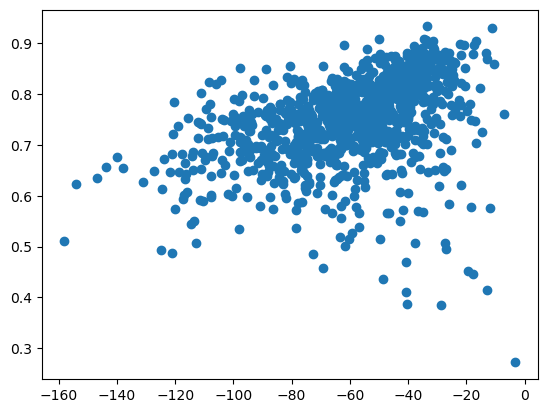

In [5]:
sentence_avg = df.groupby("instanceID")[[compare_metric, "output_logprob"]].mean().reset_index()
sentence_avg=sentence_avg[[compare_metric, "output_logprob"]]

x=sentence_avg["output_logprob"]
y=sentence_avg[compare_metric]

plt.scatter(x, y)

sentence_avg.corr()

r_squared is 0.1407338295291175


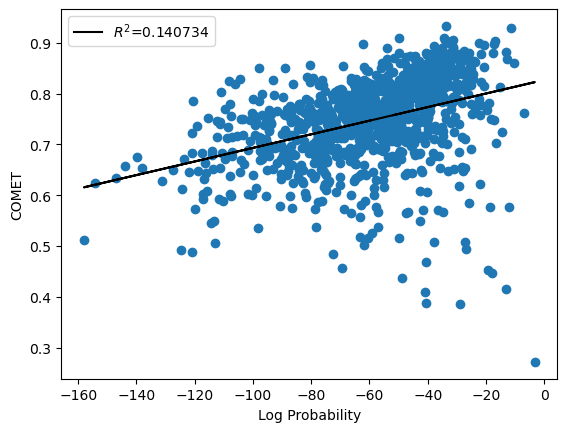

In [6]:
from sklearn.metrics import r2_score


def readable_col(col):
    rename_dict={"output_logprob": "Log Probability",
                 "example_comet":"COMET"}
    return rename_dict[col] if col in rename_dict else col

def plot_simple(df, xlabel, ylabel, title=None, trend_line="None",ax=None):
    
    if(ax is None):
        _, ax = plt.subplots()
    
    x = df[xlabel]
    y = df[ylabel]
    # Plot with error bars (standard deviation)
    ax.scatter(x,y)

    # plt.scatter(x,y)
    ax.set_xlabel(readable_col(xlabel))
    ax.set_ylabel(readable_col(ylabel))

    if(title):
        ax.set_title(title)

    if(trend_line=="None"):
        pass
    elif(trend_line=="linear"):
        try:
            z = np.polyfit(x,y, 1)
            p = np.poly1d(z)


            r_squared = r2_score(y, p(x))

            print(f"r_squared is {r_squared}")
            ax.plot(x,p(x),"k-", label=("$R^2$=%.6f"%(r_squared))  )
            ax.legend() 
        except:
            pass
    else: 
        raise Exception("Plot_keys errors: did not recognize trend_line type")
    return ax



ax=plot_simple(df=sentence_avg, xlabel="output_logprob", ylabel=compare_metric, trend_line="linear")